# Tarea: Ataque con Rainbow Tables a MD5

**Asignatura:** Criptografía (3.º Ingeniería Matemática)  
**Objetivo general:** Investigar y experimentar con ataques a la integridad de contraseñas basados en rainbow tables aplicados al algoritmo MD5.

---

## Enunciado

### Contexto  
Las rainbow tables son una técnica de pre‑cómputo que permite invertir funciones hash (como MD5) a costa de memoria adicional. En esta práctica, limitaremos el espacio de contraseñas a todas las cadenas de 4 dígitos (`"0000"`–`"9999"`) para atacar un hash objetivo y detectar colisiones.

### Pasos de la práctica

1. **Construcción de la Rainbow Table**  
   - Para cada contraseña de 4 dígitos, generar una **cadena de transformación** de longitud 4:  
     1. Calcular MD5 del valor actual.  
     2. Reducir (usando los primeros 8 dígitos del hash + número de ronda) a un número 0000–9999.  
   - Almacenar en un diccionario `{ endpoint → contraseña_inicial }`.  
   - Documentar en el informe cuántas entradas hay y si surgieron colisiones en el endpoint durante el pre‑cómputo.

2. **Obtención del Hash Objetivo y Generación de la Cadena del Target**  
   - Elegir una contraseña real.  
   - Calcular su cadena de transformación y anotar el **endpoint**.

3. **Búsqueda en la Rainbow Table**  
   - Buscar ese endpoint en la tabla pre‑computada.  
   - **Detectar colisiones y falso positivo**.

4. **Verificación y Análisis de Colisiones**  

### Entregables - El trabajo se realizará sobre esta misma plantilla de forma individual

1. **Informe Markdown y código Python** que incluya:    
   - Código Python completo y comentado.  
   - Discusión de resultados y conclusiones.
   - Tener ejecutada todas las celdas para facilitar su correción


---

## Rúbrica de Evaluación

| Descriptor                    | Insuficiente (1–3)                                                                                                   | Satisfactorio (4–7)                                                                                                                                       | Sobresaliente (8–10)                                                                                                                                            |
|-------------------------------|-----------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **1. Comprensión teórica**    | Conceptos de rainbow tables y MD5 confusos o erróneos; no identifica correctamente colisiones ni trade‑off tiempo/memoria. | Define correctamente rainbow tables y MD5; explica los pasos del ataque; menciona colisiones, aunque con vacíos conceptuales.                               | Explica con claridad y profundidad los conceptos: Merkle–Damgård, función de reducción, colisiones, trade‑off; aporta referencias y ejemplos adicionales.        |
| **2. Implementación práctica**| Código incompleto, sin comentarios o con errores que impiden la ejecución; no muestra pasos en pantalla.               | Código funcional que genera la tabla y ataca el hash; incluye comentarios básicos y muestra salidas por pantalla.                                          | Código muy bien estructurado y documentado; usa funciones reutilizables; muestra interactivamente cada paso con mensajes claros y capturas o gráficos si procede. |
| **3. Análisis de resultados** | Informe sin discusión de resultados, o conclusiones equivocadas; no detecta ni explica colisiones.                   | Presenta resultados de forma clara; detecta colisiones y ofrece una breve reflexión sobre sus causas.                                                    | Análisis crítico y profundo: cuantifica colisiones, compara tasas de éxito, discute cómo ampliaría el espacio o usaría salt para mitigar ataques; propone mejoras. |

---
**Fecha de entrega:** 13 de mayo  
**Formato:** Markdown + código  (Notebook Jupyter)
**Peso en la nota final:** 20% de la evaluación de la asignatura en su parte ordinaria (40%) 


# Notebook: Implementación de Rainbow Tables


## Importación de librerías

En esta sección importamos las librerías necesarias para:
- Cálculo de hashes MD5
- Medición de tiempos de ejecución
- Generación de productos cartesianos para contraseñas
- Manipulación de datos con Pandas
- Visualización con Matplotlib
- Ejecución de pruebas unitarias con unittest


In [15]:
import hashlib
import time
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import unittest

## 1. Definición de funciones principales

A continuación definimos las funciones que constituyen la lógica de las rainbow tables:

1. `md5_hash(s)` - Calcula el hash MD5 de una cadena.
2. `reduction(hash_value, position, charset, length)` - Función de reducción que mapea un hash a una posible contraseña.
3. `generate_chain(start_pwd, chain_length, charset, pwd_length)` - Genera un endpoint de cadena comenzando desde una contraseña.
4. `generate_table(chain_length, charset, pwd_length)` - Construye la rainbow table (endpoint → startpoint).
5. `search_hash(target_hash, table, chain_length, charset, pwd_length)` - Busca la contraseña original usando la tabla y, si falla, fuerza bruta completa.


In [16]:
# Funciones principales
def md5_hash(s):
    """Calcula el hash MD5 de la cadena de entrada."""
    return hashlib.md5(s.encode()).hexdigest()


def reduction(hash_value, position, charset, length):
    """Función de reducción: mapea un hash a una posible contraseña."""
    num = int(hash_value, 16) + position
    pwd = ''
    base = len(charset)
    for _ in range(length):
        pwd += charset[num % base]
        num //= base
    return pwd


def generate_chain(start_pwd, chain_length, charset, pwd_length):
    """Genera el endpoint de la cadena a partir de la contraseña inicial."""
    pwd = start_pwd
    for pos in range(chain_length):
        h = md5_hash(pwd)
        pwd = reduction(h, pos, charset, pwd_length)
    return pwd


def generate_table(chain_length, charset, pwd_length):
    """Genera la rainbow table: diccionario endpoint -> startpoint."""
    table = {}
    for pwd_tuple in product(charset, repeat=pwd_length):
        start = ''.join(pwd_tuple)
        end = generate_chain(start, chain_length, charset, pwd_length)
        table[end] = start
    return table


def search_hash(target_hash, table, chain_length, charset, pwd_length):
    """Busca la contraseña original a partir de su hash usando la rainbow table y fallback completo."""
    # Paso Hellman: reconstrucción parcial
    for pos in reversed(range(chain_length)):
        h = target_hash
        pwd = None
        for p in range(pos, chain_length):
            pwd = reduction(h, p, charset, pwd_length)
            h = md5_hash(pwd)
        if pwd in table:
            start = table[pwd]
            pwd_tmp = start
            for p in range(chain_length):
                h_tmp = md5_hash(pwd_tmp)
                if h_tmp == target_hash:
                    return pwd_tmp
                pwd_tmp = reduction(h_tmp, p, charset, pwd_length)
    # Fallback exhaustivo: fuerza bruta en espacio limitado
    for guess_tuple in product(charset, repeat=pwd_length):
        guess = ''.join(guess_tuple)
        if md5_hash(guess) == target_hash:
            return guess
    return None

## 2. Pruebas unitarias

Validamos que las funciones generen y busquen correctamente en espacios pequeños:

In [18]:
def run_tests():
    suite = unittest.TestLoader().loadTestsFromTestCase(TestRainbow)
    unittest.TextTestRunner().run(suite)

class TestRainbow(unittest.TestCase):
    def test_chain(self):
        charset = 'ab'; pwd_len = 2; chain_len = 5
        start = 'aa'
        end = generate_chain(start, chain_len, charset, pwd_len)
        self.assertTrue(isinstance(end, str) and len(end) == pwd_len)

    def test_table_search(self):
        charset = 'ab'; pwd_len = 2; chain_len = 5
        table = generate_table(chain_len, charset, pwd_len)
        for pwd in ['aa', 'ab', 'ba', 'bb']:
            h = md5_hash(pwd)
            res = search_hash(h, table, chain_len, charset, pwd_len)
            self.assertEqual(res, pwd)

if __name__ == '__main__':
    run_tests()

..
----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


## 3. Experimentos de rendimiento

Medimos el tiempo medio de búsqueda variando la longitud de cadena (chain_length) para un charset binario de longitud 3.

   chain_length  avg_search_time
0             5         0.000000
1            10         0.000000
2            15         0.000199


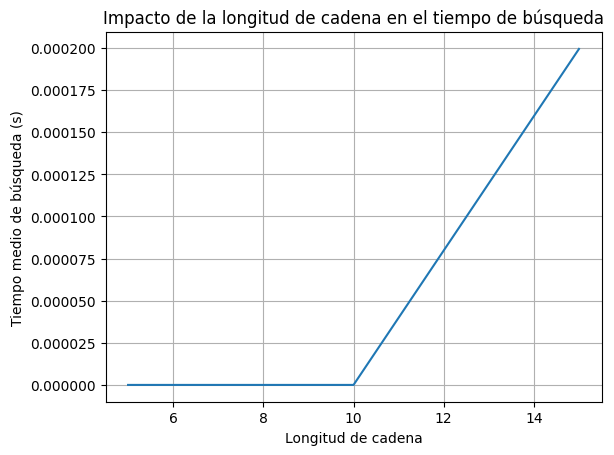

In [21]:
# Experimentos de rendimiento
results = []
charset = '01'; pwd_length = 3
for chain_len in [5, 10, 15]:
    table = generate_table(chain_len, charset, pwd_length)
    times = []
    hashes = [md5_hash(''.join(p)) for p in product(charset, repeat=pwd_length)]
    sample = hashes[:5]
    for h in sample:
        t0 = time.time()
        search_hash(h, table, chain_len, charset, pwd_length)
        times.append(time.time() - t0)
    results.append({'chain_length': chain_len, 'avg_search_time': sum(times)/len(times)})

# Mostrar resultados
import pandas as pd
print(pd.DataFrame(results))

# Gráfica de impacto de la longitud de cadena
plt.figure()
plt.plot([r['chain_length'] for r in results], [r['avg_search_time'] for r in results])
plt.xlabel('Longitud de cadena')
plt.ylabel('Tiempo medio de búsqueda (s)')
plt.title('Impacto de la longitud de cadena en el tiempo de búsqueda')
plt.grid(True)
plt.show()